In [5]:
import pandas as pd
import seaborn as sns
# Ignore useless warnings
import warnings

warnings.filterwarnings('ignore')

from scripts.load_data import load_ufo_data
from scripts.clean_data import clean_columns, preprocess_datetime, standardize_values

df = load_ufo_data("../data/scrubbed.csv")
df = clean_columns(df)
df = preprocess_datetime(df)
df = standardize_values(df)

In [6]:
df_nlp = df[["Comments"]].dropna().copy()
df_nlp["Comments"] = df_nlp["Comments"].str.lower()
df_nlp["Comments"] = df_nlp["Comments"].str.replace(r"[^a-zA-Z\s]", "", regex=True)
df_nlp["Comments"] = df_nlp["Comments"].str.replace(r"\s+", " ", regex=True)


In [7]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words="english", max_features=50)
X = vectorizer.fit_transform(df_nlp["Comments"])

word_freq = pd.DataFrame({
    "Word": vectorizer.get_feature_names_out(),
    "Frequency": X.sum(axis=0).A1
}).sort_values("Frequency", ascending=False)

print(word_freq.head(10))

      Word  Frequency
16   light      17695
17  lights      17680
37     sky      16802
27  object      14760
3   bright      13222
22  moving       9032
49   white       7399
29  orange       7313
31     red       6724
32     saw       6701


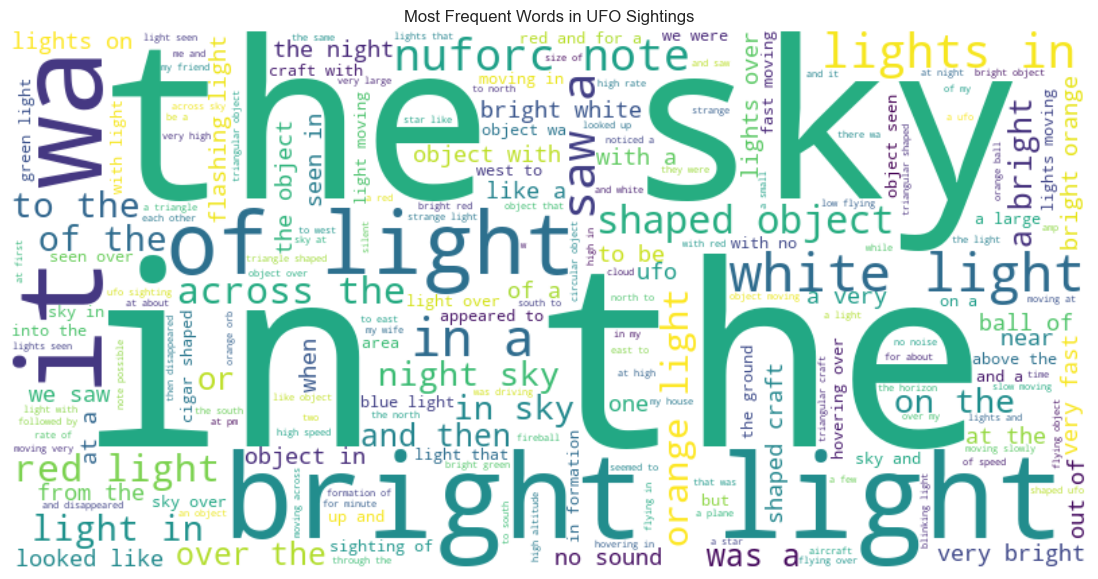

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = " ".join(df_nlp["Comments"].tolist())

wordcloud = WordCloud(width=800, height=400, background_color="white", stopwords="english").generate(text)
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in UFO Sightings")
plt.savefig("../images/wordcloud_ufo.png", dpi=300)
plt.show()

In [9]:
from textblob import TextBlob

df_nlp["Polarity"] = df_nlp["Comments"].apply(lambda text: TextBlob(text).sentiment.polarity)
df_nlp["Subjectivity"] = df_nlp["Comments"].apply(lambda text: TextBlob(text).sentiment.subjectivity)

df_nlp[["Polarity", "Subjectivity"]].describe()

,Polarity,Subjectivity
count,80317.000000,80317.000000
mean,0.103131,0.342059
std,0.215677,0.272750
min,-1.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.365000
75%,0.204762,0.533333
max,1.000000,1.000000


- Most descriptions are **neutral or mildly positive** in tone.
- A large portion of the reports are **objective**, focusing on factual observations.
- This suggests that witnesses often describe **what they saw** rather than expressing strong emotions or opinions.

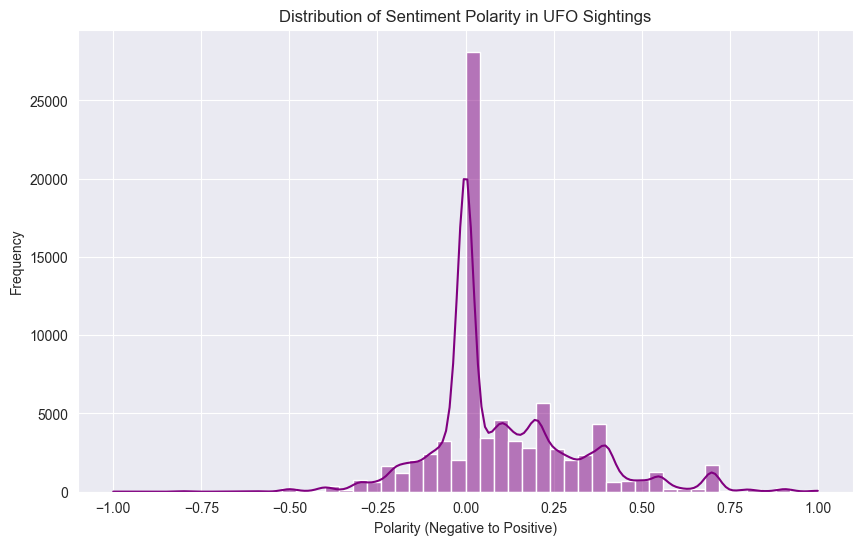

In [10]:
plt.figure(figsize=(10, 6))
sns.histplot(df_nlp["Polarity"], bins=50, kde=True, color="purple")
plt.title("Distribution of Sentiment Polarity in UFO Sightings")
plt.xlabel("Polarity (Negative to Positive)")
plt.ylabel("Frequency")
plt.show()

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

vectorizer = TfidfVectorizer(stop_words="english", max_features=1000)
X = vectorizer.fit_transform(df_nlp["Comments"])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

# Top words per topic
terms = vectorizer.get_feature_names_out()
for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx+1}:")
    print([terms[i] for i in topic.argsort()[-10:]])

Topic 1:
['th', 'night', 'seen', 'outside', 'home', 'pm', 'sky', 'driving', 'saw', 'ufo']
Topic 2:
['sky', 'light', 'hovering', 'triangular', 'flying', 'seen', 'lights', 'craft', 'object', 'shaped']
Topic 3:
['moved', 'star', 'white', 'like', 'moving', 'lights', 'object', 'bright', 'sky', 'light']
Topic 4:
['triangle', 'formation', 'red', 'object', 'bright', 'light', 'sky', 'moving', 'orange', 'lights']
Topic 5:
['object', 'ufo', 'possible', 'bright', 'sky', 'light', 'sighting', 'pd', 'nuforc', 'note']


### NLP Insights from UFO Sighting Descriptions

- Most frequent words include “light,” “object,” “bright,” and “sky,” reflecting visual characteristics of reported sightings.
- Sentiment analysis shows reports are generally **neutral to slightly positive**, with some negative outliers.
- Topic modeling revealed **distinct themes**, such as:
  - Nighttime observations
  - Descriptions of movement (e.g., hovering, fast)
  - Multiple witnesses or events
